In [1]:
from data_processing_try import *
from train_trace_3 import *

### load data

In [2]:
#data = Dataset("set1_imu.csv", "set1_tab.csv")
#data.data_set.to_csv("./data/data_frame_smooth.csv")
#data = data.data_set
#plot_ith_segment(data, 47)

In [3]:

df = pd.read_csv("./data/data_frame_smooth.csv")
data = df
# get start indices for the different segments (here a segment represents a sentence)
segment_starts = data[data["segment"].diff() != 0].index.tolist()
# so that dx at index i represents the difference to i+1
data["dx"] = data["dx"].shift(-1)
data["dy"] = data["dy"].shift(-1)

num_segments = data["segment"].iloc[-1]
feature_columns = ["ax", "ay", "az", "vel_x", "vel_y", "vel_z", "gx", "gy", "gz", "q0", "q1", "q2", "q3"]
label_columns = ["dx", "dy"]

INPUT_DIM = 13
OUTPUT_DIM = 2 


data.head()


,Unnamed: 0,t_r,x,y,z,ax,ay,az,gx,gy,...,nav_ay,nav_az,vel_x,vel_y,vel_z,pos_x,pos_y,pos_z,dx,dy
0,0,0.0,171.081563,175.444042,0.0,-0.846652,0.333538,0.358858,0.030683,-0.051090,...,-0.256070,-0.643924,0.000000,0.000000,0.000000,171.081563,175.444042,0.000000,-0.932889,-0.824417
1,1,0.5,170.148674,174.619624,0.0,-0.863770,0.266961,0.328226,-0.098304,-0.025454,...,-0.354587,-0.658915,-0.323676,-0.152664,-0.325710,171.000643,175.405875,-0.081427,-0.858081,-0.730112
2,2,1.0,169.290593,173.889512,0.0,-0.878953,0.216098,0.305050,-0.191155,-0.007150,...,-0.417381,-0.650395,-0.615088,-0.345656,-0.653037,170.765953,175.281295,-0.326114,-0.786073,-0.639797
3,3,1.5,168.504520,173.249715,0.0,-0.882562,0.259232,0.326468,-0.067845,-0.032703,...,-0.398371,-0.645887,-0.908885,-0.549594,-0.977108,170.384959,175.057483,-0.733650,-0.716863,-0.553470
4,4,2.0,167.787657,172.696245,0.0,-0.885694,0.302587,0.341227,0.028487,-0.045747,...,-0.375734,-0.645659,-1.227123,-0.743121,-1.299994,169.850957,174.734304,-1.302926,-0.650453,-0.471133


### visualize a sentence with the delta values

C:\Users\ann-k\AppData\Local\Temp\ipykernel_34320\3437357528.py:8: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if true_x != [] and true_y != []:


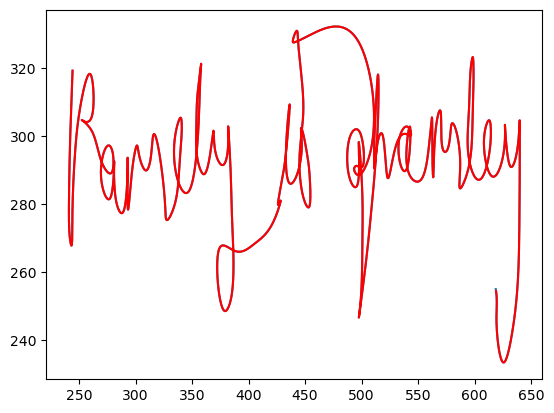

In [4]:
def print_segment_with_delta_values(start_x, start_y, dx, dy, true_x= [], true_y= []):
    x_values = [start_x]
    y_values = [start_y]
    for i in range(len(dx)):
        x_values.append(x_values[i] + dx[i])
        y_values.append(y_values[i] + dy[i])
    plt.plot(x_values, y_values)
    if true_x != [] and true_y != []:
        plt.plot(true_x, true_y, c="red")
    plt.show()

# choose random segment
segment = data[data["segment"] == 47]
segment_indices = list(range(segment_starts[47], segment_starts[48]-1))
segment_47 = data[data["segment"] == 47].index.tolist()

#print_segment_with_delta_values(segment.loc[segment.index[0], "x"], segment.loc[segment.index[0], "y"], segment.loc[segment.index[1:], "dx"].values, segment.loc[segment.index[1:], "dy"].values, segment.loc[segment.index[0:], "x"].values, segment.loc[segment.index[0:], "y"].values)
print_segment_with_delta_values(data.loc[segment_starts[47], "x"], data.loc[segment_starts[47], "y"], data.loc[segment_indices, "dx"].values, data.loc[segment_indices, "dy"].values, data.loc[segment_indices, "x"].values, data.loc[segment_indices, "y"].values)

### shape input and create batches


#### 1. approach: small batches not overlapping

In [5]:
TIME_STEMPS = 10
OFFSET = 10 # if offset < timesteps I have overlapping

# shape data into (batches, timestemps, features)
def create_segments_and_labels(dataframe: pd.DataFrame, steps, offset):
        dataframe = dataframe[dataframe.columns.intersection(feature_columns + label_columns)]
        segments = []
        labels = []
        # how many full batches can I create 
        num_batches = int((dataframe.shape[0] * INPUT_DIM) / (steps * (INPUT_DIM)))
        i = 0
        for b in range(num_batches):
            segments.append(dataframe.iloc[i: i+steps, :-2].to_numpy().flatten().tolist())
            labels.append(dataframe.iloc[i:i+steps, -2:].to_numpy().flatten().tolist()) 
            i = i + offset
        x, y = np.array(segments).reshape(-1,steps, INPUT_DIM), np.array(labels).reshape(-1,steps, OUTPUT_DIM)
        
        print("reshaped labels shape: ",y.shape, "reshaped segments shape: ", x.shape)
        return x, y


#### 2. approach: small batches overlapping

In [6]:
TIME_STEMPS = 10
OFFSET = 5 # if offset < timesteps I have overlapping

# shape data into (batches, timestemps, features)
def create_segments_and_labels(dataframe: pd.DataFrame, steps, offset):
        dataframe = dataframe[dataframe.columns.intersection(feature_columns + label_columns)]
        segments = []
        labels = []
        # how many full batches can I create 
        num_batches = int((dataframe.shape[0] * INPUT_DIM) / (steps * (INPUT_DIM)))
        i = 0
        for b in range(num_batches):
            segments.append(dataframe.iloc[i: i+steps, :-2].to_numpy().flatten().tolist())
            labels.append(dataframe.iloc[i:i+steps, -2:].to_numpy().flatten().tolist()) 
            i = i + offset
        x, y = np.array(segments).reshape(-1,steps, INPUT_DIM), np.array(labels).reshape(-1,steps, OUTPUT_DIM)
        
        print("reshaped labels shape: ",y.shape, "reshaped segments shape: ", x.shape)
        return x, y


#### 3. approach large batches not overlapping

In [7]:
TIME_STEMPS = 500
OFFSET = 500 # if offset < timesteps I have overlapping

# shape data into (batches, timestemps, features)
def create_segments_and_labels(dataframe: pd.DataFrame, steps, offset):
        dataframe = dataframe[dataframe.columns.intersection(feature_columns + label_columns)]
        segments = []
        labels = []
        # how many full batches can I create 
        num_batches = int((dataframe.shape[0] * INPUT_DIM) / (steps * (INPUT_DIM)))
        i = 0
        for b in range(num_batches):
            segments.append(dataframe.iloc[i: i+steps, :-2].to_numpy().flatten().tolist())
            labels.append(dataframe.iloc[i:i+steps, -2:].to_numpy().flatten().tolist()) 
            i = i + offset
        x, y = np.array(segments).reshape(-1,steps, INPUT_DIM), np.array(labels).reshape(-1,steps, OUTPUT_DIM)
        
        print("reshaped labels shape: ",y.shape, "reshaped segments shape: ", x.shape)
        return x, y

#### 4. approach: batches according to sentence structure

#### split into trainings and test data

In [9]:
def prepare_data_with_segments(df, test_split = 0.2,):
        print ('Split into test and trainings data...')
        scaler = StandardScaler() 
        df[feature_columns] = pd.DataFrame(scaler.fit_transform(df[feature_columns].values), index=df.index)

        split = int(num_segments * (1- test_split))
        train_data = df[df["segment"] <= split]
        # use single segment for test data for now
        test_data = data.iloc[segment_indices]

        x_train, y_train = create_segments_and_labels(train_data, TIME_STEMPS, OFFSET)
        x_test, y_test = create_segments_and_labels(test_data, TIME_STEMPS, OFFSET)

        x_train = x_train.astype('float32')
        y_train = y_train.astype('float32')
        x_test = x_test.astype('float32')
        y_test = y_test.astype('float32')

        return x_train, y_train, x_test, y_test


# create training and test data
x_train, y_train, x_test, y_test = prepare_data_with_segments(data)

Split into test and trainings data...
reshaped labels shape:  (331, 500, 2) reshaped segments shape:  (331, 500, 13)
reshaped labels shape:  (6, 500, 2) reshaped segments shape:  (6, 500, 13)


C:\Users\ann-k\AppData\Local\Temp\ipykernel_34320\3437357528.py:8: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if true_x != [] and true_y != []:


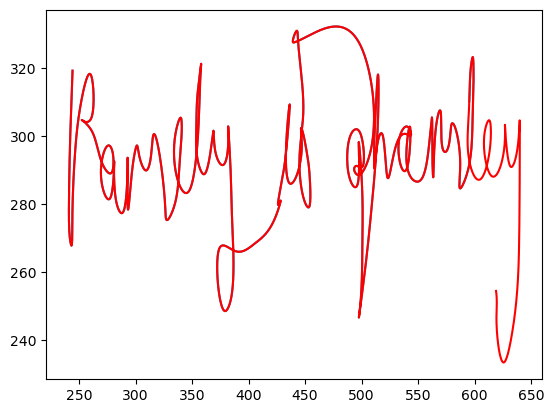

In [10]:
# check if y_test is correctly created and can be reshaped to be compared to original data
y_test = y_test.reshape(-1,2)
print_segment_with_delta_values(data.loc[segment_starts[47], "x"], data.loc[segment_starts[47], "y"], y_test[:,0], y_test[:,1], data.loc[segment_indices, "x"].values, data.loc[segment_indices, "y"].values)

#### first model


In [11]:
def def_model_0(time_stemps, num_features=INPUT_DIM):
        inp = tf.keras.layers.Input((time_stemps,num_features))
        #x = tf.keras.layers.Masking(mask_value=self.PAD_VALUE)(inp)
        x = tf.keras.layers.LSTM(128, return_sequences=True)(inp)
        #x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(64))(x) #TimeDistributed(
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.LSTM(128, return_sequences=True)(x)
        #x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(OUTPUT_DIM))(x)

        model = tf.keras.Model(inp, x)
        tf.keras.Model()
        return model

#### model for sentence batching

In [12]:
# use TimeDistributed Layer for sentence segmentation: This wrapper allows to apply a layer to every temporal slice of an input.

#### model for CNN_LSTM

In [13]:
from tensorflow import keras
from keras import layers

def def_model_1(time_stemps, num_features=INPUT_DIM):
        inp = tf.keras.layers.Input((time_stemps,num_features))
        x = tf.keras.layers.Conv1D(32, kernel_size=32)(inp)
        x = tf.keras.layers.Dropout(0.1)(x)
        x = tf.keras.layers.Conv1D(32, kernel_size=16)(x)
        x = tf.keras.layers.Dropout(0.1)(x)
        x = tf.keras.layers.MaxPooling1D(pool_size=64, padding="same")(x)
        x = tf.keras.layers.Conv1D(16, kernel_size=8)(x)
        x = tf.keras.layers.Dropout(0.1)(x)
        x = tf.keras.layers.LSTM(64, return_sequences=True)(x)
        x = tf.keras.layers.Dense(OUTPUT_DIM)(x)

        model = tf.keras.Model(inp, x)
        tf.keras.Model()
        return model

def def_model_2(time_stemps, num_features=INPUT_DIM):
        model = Sequential()
        model.add(tf.keras.layers.Input((time_stemps,num_features))) 
        model.add(tf.keras.layers.Conv1D(filters=100, kernel_size=2, activation='relu', padding="same"))  #tf.keras.layers.TimeDistributed(
        model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=6, activation='relu', padding="same")) #tf.keras.layers.TimeDistributed(
        model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dropout(0.5)))
        model.add(tf.keras.layers.MaxPooling1D(pool_size=3, padding="same")) #tf.keras.layers.TimeDistributed(
        model.add(tf.keras.layers.LSTM(100))
        model.add(tf.keras.layers.Dropout(0.5))
        model.add(tf.keras.layers.Dense(OUTPUT_DIM))
        return model


def def_model_3(time_stemps, num_features=INPUT_DIM):
        model = Sequential()
        model.add(layers.Input((time_stemps,num_features))) # none for timestamps
        model.add(layers.Conv1D(filters=512, kernel_size=5, activation="relu", padding="same"))
        model.add(layers.BatchNormalization())
        model.add(layers.MaxPooling1D(2))
        model.add(layers.Dropout(0.3))
        model.add(layers.Conv1D(filters=256, kernel_size=3, activation="relu", padding="same"))
        model.add(layers.BatchNormalization())
        model.add(layers.MaxPooling1D(2))
        model.add(layers.Dropout(0.3))
        model.add(layers.Conv1D(filters=128, kernel_size=3, activation="relu", padding="same"))
        model.add(layers.BatchNormalization())
        model.add(layers.MaxPooling1D(2))
        model.add(layers.Dropout(0.3))
        model.add(layers.Bidirectional(layers.LSTM(64, activation="tanh", return_sequences=True)))
        model.add(layers.Dropout(0.3))
        model.add(layers.Bidirectional(layers.LSTM(64, activation="tanh", return_sequences=True)))
        model.add(layers.Dense(OUTPUT_DIM))
        return model





In [14]:
print("The trainings data is of shape {} and {}". format(x_train.shape, y_train.shape))
print ('Fitting model...')

model = def_model_3(x_train.shape[1], INPUT_DIM) 

model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001), loss='mse')
print(model.summary())

print(y_train.shape)
history = model.fit(x_train, y_train, epochs= 50, validation_split=0.2)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


The trainings data is of shape (331, 500, 13) and (331, 500, 2)
Fitting model...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 500, 512)          33792     
                                                                 
 batch_normalization (BatchN  (None, 500, 512)         2048      
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 250, 512)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 250, 512)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 250, 256)          393472    
                                         

c:\Users\ann-k\anaconda3\envs\patternRecognition2\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


ValueError: in user code:

    File "c:\Users\ann-k\anaconda3\envs\patternRecognition2\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\ann-k\anaconda3\envs\patternRecognition2\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\ann-k\anaconda3\envs\patternRecognition2\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\ann-k\anaconda3\envs\patternRecognition2\lib\site-packages\keras\engine\training.py", line 994, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\Users\ann-k\anaconda3\envs\patternRecognition2\lib\site-packages\keras\engine\training.py", line 1052, in compute_loss
        return self.compiled_loss(
    File "c:\Users\ann-k\anaconda3\envs\patternRecognition2\lib\site-packages\keras\engine\compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "c:\Users\ann-k\anaconda3\envs\patternRecognition2\lib\site-packages\keras\losses.py", line 152, in __call__
        losses = call_fn(y_true, y_pred)
    File "c:\Users\ann-k\anaconda3\envs\patternRecognition2\lib\site-packages\keras\losses.py", line 272, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "c:\Users\ann-k\anaconda3\envs\patternRecognition2\lib\site-packages\keras\losses.py", line 1486, in mean_squared_error
        return backend.mean(tf.math.squared_difference(y_pred, y_true), axis=-1)

    ValueError: Dimensions must be equal, but are 62 and 500 for '{{node mean_squared_error/SquaredDifference}} = SquaredDifference[T=DT_FLOAT](sequential/dense/BiasAdd, IteratorGetNext:1)' with input shapes: [?,62,2], [?,500,2].


1/1 [==============================] - 0s 380ms/step


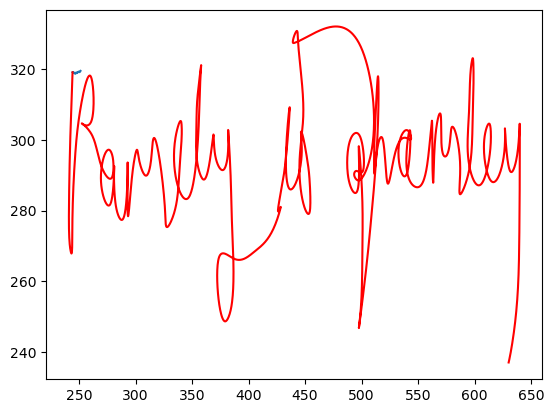

In [ ]:
y_pred = model.predict(x_test, batch_size=100)

y_pred = y_pred.reshape(-1,2)
start_x = data.loc[segment_starts[47], "x"]
start_y = data.loc[segment_starts[47], "y"]

y_test = y_test.reshape(-1,2)

x_values = [start_x]
y_values = [start_y]
for i in range(0,len(y_test)-1): # 0 statt 1
    x_values.append(x_values[i] + y_test[i,0]) # minus 1 bei values weggenommmen
    y_values.append(y_values[i] + y_test[i,1])
# bei pred bei 0 angefangen
print_segment_with_delta_values(start_x, start_y, y_pred[:,0], y_pred[:,1], x_values, y_values)

#### loss function (for segmentation for labeling handwriting sequences)
The CTC is an RNN loss function that enables labeling whole sequences at once. It uses the network to provide direct mapping from an input sequence to an output label
without the need of segmenting the data. It introduces a ‘blank’ character that
is used to find the best alignment of characters that best interprets the input.
(https://arxiv.org/pdf/2105.12434.pdf)
https://keras.io/examples/audio/ctc_asr/

